<div class="alert alert-info">
    
➡️ Make sure that you have read the **[rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins)** and the **[policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating)** before starting with this lab.

➡️ Make sure you fill in any cells (and _only_ those cells) that say **`YOUR CODE HERE`** or **YOUR ANSWER HERE**, and do _not_ modify any of the other cells.

➡️ **Before you submit your lab, make sure everything runs as expected.** For this, _restart the kernel_ and _run all cells_ from top to bottom. In Jupyter Notebook version 7 or higher, you can do this via "Run$\rightarrow$Restart Kernel and Run All Cells..." in the menu (or the "⏩" button in the toolbar).

</div>

# L3: Text clustering and topic modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

In [1]:
# Define some helper functions that are used in this notebook

%matplotlib inline
from IPython.display import display, HTML

def success():
    display(HTML('<div class="alert alert-success"><strong>Solution appears correct!</strong></div>'))

## Hard clustering data set

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [2]:
import pandas as pd
import bz2

with bz2.open('reviews.json.bz2') as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [3]:
df.head()

,category,sentiment,text
0,music,neg,i bought this album because i loved the title ...
1,music,neg,i was misled and thought i was buying the enti...
2,books,neg,"i have introduced many of my ell , high school..."
3,books,pos,anything you purchase in the left behind serie...
4,dvd,pos,"i loved these movies , and i cant wiat for the..."


## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and a $k$-means clusterer.

### Task 1.1

Start by doing the vectorization. In connection with vectorization, you should also filter out standard English stop words. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

After running the following cell:
- `vectorizer` should contain the vectorizer fitted on `df['text']`
- `reviews` should contain the vectorized `df['text']`

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
reviews = vectorizer.fit_transform(df['text'])

#### 🤞 Test your code

If you used the English stop word list from scikit-learn, then the resulting vocabulary should have 46,619 entries.  You can check this by running the following code cell:

In [5]:
"""Check that the vectorized text column has the right dimensions."""

assert reviews.shape == (11914, 46619), f"Wrong dimensions: {reviews.shape}"
success()

### Task 1.2

Next, cluster the vectorized data. Before doing so, you should read the documentation of the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which is scikit-learn&rsquo;s implementation of the $k$-means algorithm. As you can see, this class has several parameters that you can tweak. For now, the only parameter that you will have to set is the number of clusters. Start with $k=3$.

**Tip:** Training $k$-means models will take some time. To speed things up, you can use the `n_init` parameter to control the number of times that the clustering is re-computed with different initial values. The default value for this parameter is 10; here and in the rest of this lab, you may want to set this to a lower value, or simply to "auto".

In [6]:
from sklearn.cluster import KMeans

def fit_kmeans(data, n_clusters):
    """Fit a k-means classifier to some data.

    Arguments:
        data: The vectorized data to train the classifier on.
        n_clusters (int): The number of clusters.

    Returns:
        The trained k-means classifier.
    """
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto').fit(data) 
    return(kmeans)

To sanity-check your clustering, create a bar plot with the number of documents per cluster.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cluster_size(kmeans):
    """Produce & display a bar plot with the number of documents per cluster.

    Arguments:
        kmeans: The trained k-means classifier.
    """
    x = np.arange(len(np.bincount(kmeans.labels_)))
    y = np.bincount(kmeans.labels_)
    plt.bar(x, y)

#### 🤞 Test your code

The following cell shows how your code should run.  The output of the cell should be the bar plot of the cluster sizes.  Note that sizes may vary considerable between clusters and among different random seeds, so there is no single “correct” output here!

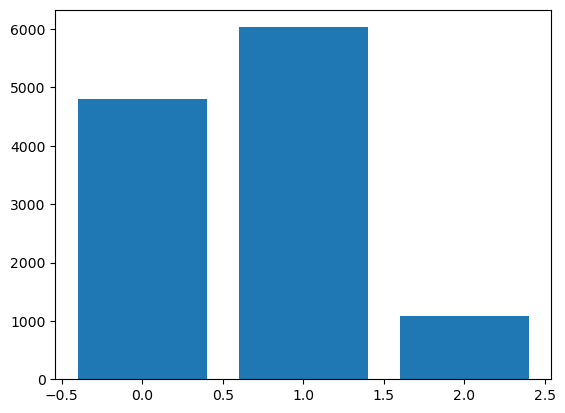

In [8]:
kmeans = fit_kmeans(reviews, 3)
plot_cluster_size(kmeans)

## Problem 2: Summarize clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to generate a **summary** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

(Hint: You will need to figure out how to use the vectorizer to convert indices back into the terms they represent.)

In [9]:
import numpy as np

def compute_cluster_summaries(kmeans, vectorizer, top_n):
    """Compute the top_n highest-weighted terms from the centroid of each cluster.

    Arguments:
        kmeans: The trained k-means classifier.
        vectorizer: The fitted vectorizer; needed to obtain the actual terms
                    belonging to the items in the cluster.
        top_n: The number of terms to return for each cluster.

    Returns:
        A list of length k, where k is the number of clusters. Each item in the list
        should be a list of length `top_n` with the highest-weighted terms from that
        cluster.  Example:
          [["first", "foo", ...], ["second", "bar", ...], ["third", "baz", ...]]
    """
    # Cluster center argsorted and read from tail (closest first). We then take out the top_n words for each row (row = cluster).
    top_term_indices = kmeans.cluster_centers_.argsort()[:, ::-1][:,:top_n] 
    # Map the indices to the vectorizer feature names and create a list with 3 lists of these feature names.
    return [list(vectorizer.get_feature_names_out()[i]) for i in top_term_indices] 

### 🤞 Test your code

The following cell runs your code with `top_n=10`, checks that the returned lists have the expected dimensions, and prints the summaries:

In [10]:
summaries = compute_cluster_summaries(kmeans, vectorizer, 10)

assert isinstance(summaries, list) and len(summaries) == 3, "Return value should be a list of length 3 (the number of clusters)"
assert all(len(summary) == 10 for summary in summaries), "Each list should contain exactly 10 terms"
assert all(isinstance(term, str) for s in summaries for term in s), "Each list should contain strings"
success()

for idx, terms in enumerate(summaries):
    print(f"Cluster {idx}: {', '.join(terms)}")

Cluster 0: product, use, software, does, program, used, great, easy, work, just
Cluster 1: book, movie, like, album, cd, just, music, great, good, quot
Cluster 2: camera, lens, pictures, canon, digital, use, flash, battery, quality, great


Once you have computed the cluster summaries, take a minute to reflect on their quality. Is it clear what the reviews in a given cluster are about? Do the cluster summaries contain any unexpected terms?

## Problem 3: Compare clusterings using the Rand index

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents. In these cases you can compute the **Rand index** of a clustering, and use this measure to compare the quality of different clusterings.

To compute the Rand index, we view a clustering as a binary classifier on (unordered) pairs of documents. The classifier predicts &lsquo;positive&rsquo; if and only if the two documents belong to the same cluster. The (non-normalized) Rand index of the clustering is the accuracy of this classifier relative to a reference in which a document pair belongs to the &lsquo;positive&rsquo; class if and only if the two documents in the pair have the same gold-standard class label.

### Task 3.1

Implement a function that computes the Rand index “manually”, i.e., _without_ importing an external function from a library.

In [11]:
def rand_index(pred_labels, gold_labels):
    """Compute the Rand index.

    Arguments:
        pred_labels: The predicted labels.
        gold_labels: The gold-standard labels.

    Returns:
        The Rand index (a single number).
    """
    # Take out pair indices. All combinations of pairs
    pairs = [(i, j) for i in range(len(pred_labels)) for j in range(i + 1, len(pred_labels))]
    
    # For each pair of documents, consider:
    # 1. Do they belong to the same cluster?
    # 2. Should they belong to the same cluster?
    # -> Count agreeing pairs.
    agreeing_pairs = sum(1 for i,j in pairs 
                        if (pred_labels[i] == pred_labels[j] and gold_labels[i] == gold_labels[j]) or
                           (pred_labels[i] != pred_labels[j] and gold_labels[i] != gold_labels[j]))

    # ri = nr of agreeing pairs / nr of all pairs
    return agreeing_pairs / len(pairs)

#### 🤞 Test your code

The following cell computes the Rand index on some “toy” examples to check if your implementation is correct:

In [12]:
assert rand_index([0, 0, 0], [0, 1, 2]) == 0.0
assert rand_index([1, 2, 0], [0, 1, 2]) == 1.0
assert rand_index([1, 2, 1, 2], [0, 1, 2, 2]) == 0.5
success()

### Task 3.2

Using your implementation of the Rand index, compare the performance of different k-means clusters with $k \in \{1,2,3,5,7\}$ clusters. As your evaluation data, use the first 500 documents from the original data set along with their gold-standard categories (from the `category` column).

Your implementation should print the computed Rand index for each of the values for $k$.

In [28]:
k_values = (1,2,3,5,7, 10, 20, 50, 100)
rand_indices = [rand_index(fit_kmeans(data=reviews, n_clusters=k).labels_[:500], df['category'][:500]) for k in k_values]

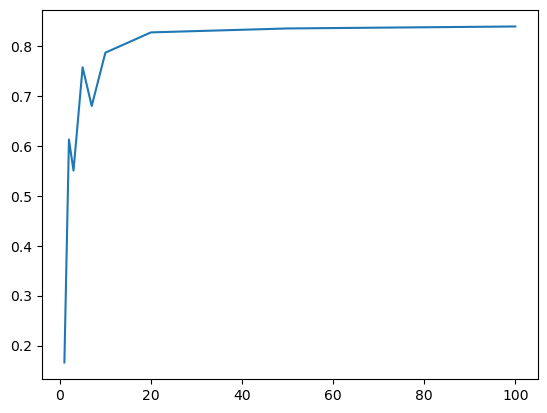

In [29]:
plt.plot(k_values, rand_indices)

Give a brief summary of your results!

As seen in the list above, using 7 clusters yields the highest rand index. Rand index is a similarity measure between two clusterings. This means that kmeans using 7 clusters yields the most similar clustering to the gold standard categories, where each categorie is seen as a cluster. This seems reasonable, since looking at the reviews data, there are 6 categories, so at least using 1,2 or 3 clusters will not yield as good results. Adding too many clusters will overfit the data.

In [14]:
# Nr of categories in the reviews
np.unique(df['category'][:500]).size

6

## Problem 4: Train a topic model

### Data set

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [15]:
from itertools import islice

with open('sotu_1975_2000.txt') as source:
    # Print the first 5 lines only
    for line in islice(source, 5):
        print(line.rstrip())

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

Take a few minutes to think about what topics you would expect in this data set.

### Task 4.1

Your first task on the topic modelling data is to train an LDA model. For this task you will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.

Start by preprocessing the data using spaCy.  Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length. Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [16]:
import spacy

nlp = spacy.load("en_core_web_sm")

def load_and_preprocess_documents(filename="sotu_1975_2000.txt"):
    """Load and preprocess all documents in the given file.

    The preprocessing must filter out stop words, non-alphabetic tokens,
    and tokens less than 3 characters in length.

    Returns:
        A list of length n, where n is the number of documents.
        Each item in the list should be a list of tokens in the given
        document, after preprocessing.
    """
    # Load documents. Each line corresponds to a sentence, which is transformed into a spacy object. 
    # Tokens are then filtered out as described, and saved in the documents list as strings (not spacy tokens).
    with open(filename) as source:
        docs = [[token.text for token in nlp(line.rstrip()) if len(token) > 2 and token.is_alpha and not token.is_stop] for line in source]
    return docs

#### 🤞 Test your code

Test your preprocessing by running the following cell. It will output the tokens (after preprocessing) for an example document and compare them against the expected output.

In [17]:
documents = load_and_preprocess_documents()

assert len(documents) == 2898, "The number of documents should equal the number of lines in the input file"
print(f"document  0 after preprocessing: {' '.join(documents[0])}")
assert " ".join(documents[0]) == "speaker vice president members congress distinguished guests"
print(f"document 42 after preprocessing: {' '.join(documents[42])}")
assert " ".join(documents[42]) == "reduce oil imports million barrels day end year million barrels day end", "The output for document 42 does not appear to be correct"
success()

document  0 after preprocessing: speaker vice president members congress distinguished guests
document 42 after preprocessing: reduce oil imports million barrels day end year million barrels day end


### Task 4.2

Now that you have the list of documents, skim the section [Pre-process and vectorize the documents](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the gensim documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim. _(Note that you cannot use the standard scikit-learn pipeline in this case.)_ Then, write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) for $k=10$ topics, and using default values for all other parameters.

In [18]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

def train_lda_model(documents, num_topics, passes=1):
    """Create and train an LDA model.

    Arguments:
        documents: The preprocessed documents, as produced in Task 4.1.
        num_topics: The number of topics to generate.
        passes: The number of training passes. Defaults to 1; you will need
                this later for Task 5.

    Returns:
        The trained LDA model.
    """
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(documents)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    # Is this needed? Should we include bigrams?
    dictionary.filter_extremes(no_below=20, no_above=0.5)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    return LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        passes=passes,
        random_state=123, # For reproducability
    )

#### 🤞 Test your code

Run the following cell to test your code and print the topics:

In [19]:
model = train_lda_model(documents, 10)
model.print_topics()

[(0,
  '0.031*"children" + 0.015*"people" + 0.014*"america" + 0.012*"americans" + 0.012*"years" + 0.011*"year" + 0.011*"century" + 0.011*"care" + 0.011*"world" + 0.011*"tonight"'),
 (1,
  '0.028*"america" + 0.020*"world" + 0.014*"american" + 0.014*"know" + 0.012*"peace" + 0.011*"people" + 0.010*"trade" + 0.010*"new" + 0.009*"help" + 0.008*"let"'),
 (2,
  '0.019*"years" + 0.017*"security" + 0.016*"new" + 0.014*"world" + 0.013*"people" + 0.012*"percent" + 0.012*"rate" + 0.012*"social" + 0.012*"american" + 0.011*"year"'),
 (3,
  '0.020*"people" + 0.018*"welfare" + 0.016*"work" + 0.016*"tonight" + 0.015*"tax" + 0.015*"year" + 0.014*"years" + 0.014*"new" + 0.012*"america" + 0.008*"time"'),
 (4,
  '0.023*"crime" + 0.022*"people" + 0.015*"america" + 0.015*"years" + 0.014*"opportunity" + 0.013*"work" + 0.012*"families" + 0.012*"year" + 0.011*"start" + 0.011*"american"'),
 (5,
  '0.019*"new" + 0.014*"america" + 0.013*"americans" + 0.012*"year" + 0.010*"economic" + 0.010*"national" + 0.010*"cut"

Inspect the topics. Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics match your expectations?

## Problem 5: Monitor a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs (or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [20]:
import logging

logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

def clear_logfile():
    # To empty the log file
    with open("gensim.log", "w"):
        pass

The following function will parse the generated logfile and return the list of log likelihoods.

In [21]:
import re

def parse_logfile():
    """Parse gensim.log to extract the log-likelihood scores.

    Returns:
        A list of log-likelihood scores.
    """
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Here's an example how to run it — note that we call `clear_logfile()` to empty the logfile before training the model. If your code from problem 4 was correct, the result should be a list with a single log-likehoodscore, since we are doing a single training pass:

In [22]:
clear_logfile()
model = train_lda_model(documents, 10, passes=1)
likelihoods = parse_logfile()
print(likelihoods)

[-6.895]


### Task 5.1

Your task now is to write re-train your LDA model for 50&nbsp;passes, retrieve the list of log likelihoods, and create a plot from this data.

In [23]:
def plot_likelihoods(likelihoods):
    """Produce & display a plot of the log-likelihood scores during training.

    Arguments:
        likelihoods: A list of scores, as returned by `parse_logfile()`.
    """
    plt.plot(likelihoods) # Seems resonable to just plot as a time series.

#### 🤞 Test your code

Once you've implemented the plotting function, you can run the LDA model with 50 passes (this will take a moment) and plot the resulting scores:

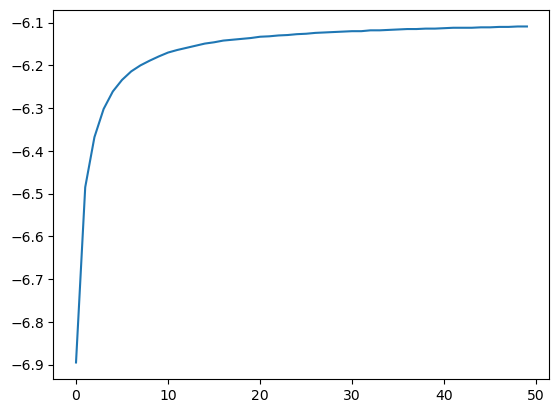

In [24]:
clear_logfile()
model = train_lda_model(documents, 10, passes=50)
likelihoods = parse_logfile()
plot_likelihoods(likelihoods)

### Task 5.2

How do you interpret the plot you produced in Task 5.1? Based on the plot, what would be a reasonable choice for the number of passes? Retrain your LDA model with that number and re-inspect the topics it finds.

In [25]:
# Retraining the model with 15 passes.
model = train_lda_model(documents, 10, passes=15)
model.print_topics()

[(0,
  '0.059*"children" + 0.024*"parents" + 0.020*"schools" + 0.018*"child" + 0.016*"america" + 0.015*"community" + 0.015*"tonight" + 0.014*"work" + 0.014*"help" + 0.014*"teachers"'),
 (1,
  '0.064*"world" + 0.045*"america" + 0.035*"peace" + 0.020*"freedom" + 0.020*"trade" + 0.017*"united" + 0.016*"human" + 0.016*"states" + 0.015*"people" + 0.014*"american"'),
 (2,
  '0.038*"years" + 0.028*"percent" + 0.023*"tax" + 0.023*"social" + 0.021*"year" + 0.021*"security" + 0.017*"education" + 0.016*"spending" + 0.016*"federal" + 0.016*"inflation"'),
 (3,
  '0.040*"welfare" + 0.032*"work" + 0.028*"years" + 0.021*"people" + 0.016*"ago" + 0.015*"year" + 0.014*"time" + 0.012*"tax" + 0.012*"reform" + 0.011*"tonight"'),
 (4,
  '0.036*"right" + 0.035*"crime" + 0.028*"people" + 0.019*"let" + 0.017*"family" + 0.017*"private" + 0.015*"tax" + 0.015*"way" + 0.014*"work" + 0.014*"rights"'),
 (5,
  '0.044*"new" + 0.034*"government" + 0.024*"policy" + 0.023*"energy" + 0.021*"administration" + 0.020*"economi

Write a **brief** paragraph explaining how you chose the number of passes, and whether or not you consider the new topics to be &lsquo;better&rsquo; than the ones that you got from the 1-pass model in Problem&nbsp;4.

Looking at the plot above its easy to see that the model quickly improves in terms of log likelihood. After only about 5 iterations the model has improved significantly, and after about 15 iterations the model has converged, so we concluded that about 15 iterations should be sufficient.

Looking at the new topics, it is difficult to say whether the new topics are 'better'. For example, looking at topic 8, the retrained model include the word 'soviet', but not 'europe'. topic 8 on the first model instead does not include 'soviet', but includes 'europe'. Without knowing the underlying text, this could have a quite big impact on the actual topics of the text, considering the rest of the words such as 'security' and 'nuclear'. Knowing the underlying text is state of the union speeches, it however seems more reasonable that 'soviet' would be included 

**Congratulations on finishing this lab! 👍**

<div class="alert alert-info">
    
➡️ Don't forget to **test that everything runs as expected** before you submit!

</div>